In [1]:
import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
import importlib
from configobj import ConfigObj
from scipy.linalg.lapack import dgesv
from TackleBox import Set_Bait, Fish, CovRenorm, compute_full_deriv_gg, compute_deriv_alphas_gg,compute_full_deriv, compute_deriv_alphas,compute_full_deriv_gu, compute_deriv_alphas_gu,compute_full_deriv_uu, compute_deriv_alphas_uu
from ioutils import CosmoResults, InputData, write_fisher

# Read in the config file
pardict = ConfigObj(configpath)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)
print("#  Data nbar")
print(data.nbar)
print("#  Data bias")
print(data.bias)

# Precompute some things we might need for the Fisher matrix
recon, derPalpha, derPalpha_BAO_only = Set_Bait(cosmo, data, BAO_only=pardict.as_bool("BAO_only"))
print("#  Data recon factor")
print(recon)

# Loop over redshifts and compute the Fisher matrix and output the 3x3 matrix
identity = np.eye(len(data.nbar) + 3)
print(
    "#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)"
)
erralpha = np.zeros(len(cosmo.z))
FullCatch = np.zeros((len(cosmo.z) * len(data.nbar) + 3, len(cosmo.z) * len(data.nbar) + 3))
for iz in range(len(cosmo.z)):

    if np.any(data.nz[:, iz] > 1.0e-30):

        Catch = Fish(
            cosmo,
            cosmo.kmin,
            cosmo.kmax,
            data,
            iz,
            recon[iz],
            derPalpha,
            pardict.as_bool("BAO_only"),
            pardict.as_bool("GoFast"),
        )
        # print(Catch)

        # Add on BAO only information from kmax to k = 0.5 Mpc/h but only for alpha_perp and alpha_par
        ExtraCatch = Fish(
            cosmo,
            cosmo.kmax,
            0.5,
            data,
            iz,
            recon[iz],
            derPalpha_BAO_only,
            True,
            pardict.as_bool("GoFast"),
        )
        Catch[-2:, -2:] += ExtraCatch[-2:, -2:]

        # Add the Fisher matrix to the full fisher matrix
        FullCatch[
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
            iz * len(data.nbar) : (iz + 1) * len(data.nbar),
        ] += Catch[: len(data.nbar), : len(data.nbar)]
        FullCatch[iz * len(data.nbar) : (iz + 1) * len(data.nbar), -3:,] += Catch[: len(data.nbar), -3:]
        FullCatch[-3:, iz * len(data.nbar) : (iz + 1) * len(data.nbar)] += Catch[-3:, : len(data.nbar)]
        FullCatch[-3:, -3:] += Catch[-3:, -3:]

        # Invert the Fisher matrix to get the parameter covariance matrix
        cov = dgesv(Catch, identity)[2]

        # Compute the error on isotropic alpha also
        J = np.array([2.0 / 3.0, 1.0 / 3.0])
        erralpha[iz] = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)

        # Renormalise the covariance from fsigma8, alpha_perp, alpha_par to fsigma8, Da, H
        means = np.array([cosmo.f[iz] * cosmo.sigma8[iz], cosmo.da[iz], cosmo.h[iz]])
        cov_renorm = CovRenorm(cov, means)

        # Print the parameter means and errors
        errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
        print(
            " {0:.2f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

        # Output the fisher matrix for the redshift bin
        write_fisher(pardict, cov_renorm, cosmo.z[iz], means)

    else:
        erralpha[iz] = 1.0e30
        print(
            " {0:.2f}     {1:.4f}    {2:.3f}         -          {4:.1f}         -         {6:.1f}         -          -".format(
                cosmo.z[iz],
                cosmo.volume[iz] / 1e9,
                means[0],
                errs[0],
                means[1],
                errs[1],
                means[2],
                errs[2],
                erralpha[iz],
            )
        )

# Run the cosmological parameters at the centre of the combined redshift bin
identity = np.eye(len(cosmo.z) * len(data.nbar) + 3)
cosmo = CosmoResults(pardict, np.atleast_1d(data.zmin[0]), np.atleast_1d(data.zmax[-1]))

# Invert the Combined Fisher matrix to get the parameter
# covariance matrix and compute means and errors
cov = dgesv(FullCatch, identity)[2]
J = np.array([2.0 / 3.0, 1.0 / 3.0])
erralpha = 100.0 * np.sqrt(J @ cov[-2:, -2:] @ J.T)
means = np.array([cosmo.f[0] * cosmo.sigma8[0], cosmo.da[0], cosmo.h[0]])
cov_renorm = CovRenorm(cov, means)
errs = 100.0 * np.sqrt(np.diag(cov_renorm)[-3:]) / means
print("#  Combined errors")
print("#=================")
print(
    " {0:.2f}    {1:.4f}     {2:.3f}       {3:.2f}         {4:.1f}       {5:.2f}        {6:.1f}       {7:.2f}       {8:.3f}".format(
        cosmo.z[0],
        cosmo.volume[0] / 1e9,
        means[0],
        errs[0],
        means[1],
        errs[1],
        means[2],
        errs[2],
        erralpha,
    )
)

/root/enidh/code/capstone/Capstone-Project/ioutils.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04580784]]
#  Data bias
[[1.37583381]]
#  Data recon factor
[0.5]
#  z  V(Gpc/h)^3  fsigma8  fsigma8_err(%)  Da(Mpc/h)  Da_err(%)  H(km/s/Mpc)  H_err(%)   alpha_err(%)
 0.05    0.0356     0.441       9.89         209.4       6.62        69.0       13.84       4.917
#  Combined errors
#=================
 0.05    0.0356     0.441       9.89         209.4       6.62        69.0       13.84       4.917


/root/enidh/code/capstone/Capstone-Project/ioutils.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#  Data nbar
[[0.04580784]]
#  Data bias
[[1.37583381]]
#  Data recon factor
[0.5]
[0.0035     0.0085404  0.01358081 0.01862121 0.02366162 0.02870202
 0.03374242 0.03878283 0.04382323 0.04886364 0.05390404 0.05894444
 0.06398485 0.06902525 0.07406566 0.07910606 0.08414646 0.08918687
 0.09422727 0.09926768 0.10430808 0.10934848 0.11438889 0.11942929
 0.1244697  0.1295101  0.13455051 0.13959091 0.14463131 0.14967172
 0.15471212 0.15975253 0.16479293 0.16983333 0.17487374 0.17991414
 0.18495455 0.18999495 0.19503535 0.20007576 0.20511616 0.21015657
 0.21519697 0.22023737 0.22527778 0.23031818 0.23535859 0.24039899
 0.24543939 0.2504798  0.2555202  0.26056061 0.26560101 0.27064141
 0.27568182 0.28072222 0.28576263 0.29080303 0.29584343 0.30088384
 0.30592424 0.31096465 0.31600505 0.32104545 0.32608586 0.33112626
 0.33616667 0.34120707 0.34624747 0.35128788 0.35632828 0.36136869
 0.36640909 0.37144949 0.3764899  0.3815303  0.38657071 0.39161111
 0.39665152 0.40169192 0.40673232 0.41177273 0

/tmp/ipykernel_1731/4197366483.py:84: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  pk0 = simps(pkmod, muvec, axis=-1)
/tmp/ipykernel_1731/4197366483.py:85: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  pk2 = 5.0 * simps(pkmod * L2, muvec, axis=-1)
/tmp/ipykernel_1731/4197366483.py:86: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  pk4 = 9.0 * simps(pkmod * L4, muvec, axis=-1)
/tmp/ipykernel_1731/4197366483.py:87: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  pk0smooth = simps(pkmodsmooth, muvec, axis=-1)
/tmp/ipykernel_1731/4197366483.py:88: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson'

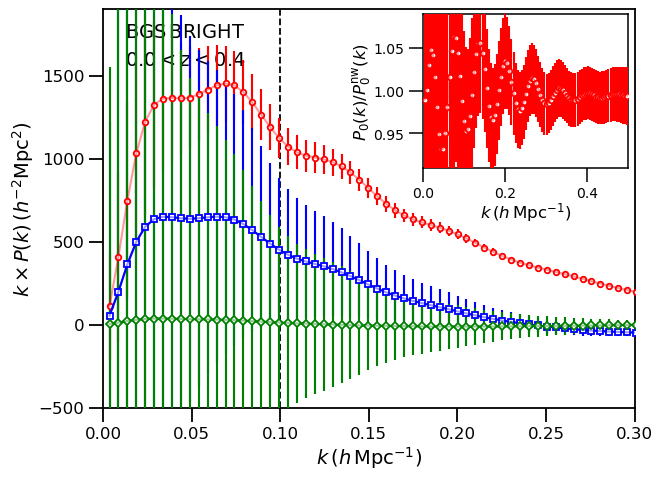

In [6]:
# Simple code to use some GoFish routines to compute a model power spectrum
# with some error bars

import sys
import os
parent = os.path.abspath("..")
sys.path.append(parent)
configpath = os.path.join(parent, "test.ini")
import numpy as np
from configobj import ConfigObj
from ioutils import CosmoResults, InputData
from TackleBox import compute_recon
from scipy.integrate import simps
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt


# Read in the config file
pardict = ConfigObj(configpath)

# Read in the file containing the redshift bins, nz and bias values
data = InputData(pardict)

# Set up the linear power spectrum and derived parameters based on the input cosmology
cosmo = CosmoResults(pardict, data.zmin, data.zmax)
if np.any(data.volume > 0):
    cosmo.volume = data.volume * 1.0e9

# Convert the nz to nbar in (h/Mpc)^3
data.convert_nbar(cosmo.volume, float(pardict["skyarea"]))

# Scales the bias so that it goes as b/G(z)
if pardict.as_bool("scale_bias"):
    data.scale_bias(cosmo.growth)
print("#  Data nbar")
print(data.nbar)
print("#  Data bias")
print(data.bias)

recon = compute_recon(cosmo, data)
print("#  Data recon factor")
print(recon)

# Produce power spectra for each sample as a function of k and mu
# Compute the kaiser factors for each galaxy sample at the redshift as a function of mu
muvec = np.linspace(0.0, 1.0, 100)
dkvec, dkout = 0.001, 0.005
ncomb = int(np.round(dkout / dkvec))
kout = (
    np.linspace(cosmo.kmin, cosmo.kmax, int((cosmo.kmax - cosmo.kmin) / dkout), endpoint=False)
    + dkout / 2.0
)
kvec = (
    np.linspace(cosmo.kmin, cosmo.kmax, int((cosmo.kmax - cosmo.kmin) / dkvec), endpoint=False)
    + dkvec / 2.0
)
print(kout, kvec)
labels = [r"$\mathrm{BGS\,BRIGHT}$", r"$\mathrm{LRG}$", r"$\mathrm{ELG\_LOP}$", r"$\mathrm{Quasar}$"]
labels2 = [r"$0.0 < z < 0.4$", r"$0.4 < z < 1.1$", r"$1.1 < z < 1.6$", r"$1.6 < z < 2.1$"]

for iz, (label, label2, ymin, ymax) in enumerate(
    zip(
        labels[:1],
        labels2[:1],
        np.array([-500.0]),
        np.array([1900.0]),
    )
):
    kaiser = np.tile(data.bias[iz, iz], (len(muvec), 1)).T + cosmo.f[iz] * muvec ** 2

    # Compute the BAO damping factor parameter after reconstruction at the redshift of interest
    # as a function of k and mu.
    Dpar = np.outer(muvec ** 2, kvec ** 2) * cosmo.Sigma_par[iz] ** 2
    Dperp = np.outer(1.0 - muvec ** 2, kvec ** 2) * cosmo.Sigma_perp[iz] ** 2
    Dfactor = np.exp(-(recon[iz] ** 2) * (Dpar + Dperp) / 2.0)

    # Compute the model 2D power spectrum
    pkmod = (kaiser.T ** 2 * splev(kvec, cosmo.pk[iz]) * Dfactor).T
    pkmodsmooth = (kaiser.T ** 2 * splev(kvec, cosmo.pksmooth[iz]) * Dfactor).T

    # Integrate the 2D model over mu to get the multipoles
    L2 = 1.0 / 2.0 * (3.0 * muvec ** 2 - 1.0)
    L4 = 1.0 / 8.0 * (35.0 * muvec ** 4 - 30.0 * muvec ** 2 + 3.0)
    pk0 = simps(pkmod, muvec, axis=-1)
    pk2 = 5.0 * simps(pkmod * L2, muvec, axis=-1)
    pk4 = 9.0 * simps(pkmod * L4, muvec, axis=-1)
    pk0smooth = simps(pkmodsmooth, muvec, axis=-1)
    pk2smooth = 5.0 * simps(pkmodsmooth * L2, muvec, axis=-1)
    pk4smooth = 9.0 * simps(pkmodsmooth * L4, muvec, axis=-1)
    pk0cov = simps((pkmod + 1.0 / data.nbar[iz, iz]) ** 2, muvec, axis=-1) / cosmo.volume[iz]
    pk2cov = (
        2.0
        * 25.0
        * simps((pkmod + 1.0 / data.nbar[iz, iz]) ** 2 * L2 ** 2, muvec, axis=-1)
        / cosmo.volume[iz]
    )
    pk4cov = (
        2.0
        * 81.0
        * simps((pkmod + 1.0 / data.nbar[iz, iz]) ** 2 * L4 ** 2, muvec, axis=-1)
        / cosmo.volume[iz]
    )

    npts = len(kvec) - (len(kvec) % ncomb)
    kvec = kvec[:npts]
    pk0 = pk0[:npts]
    pk2 = pk2[:npts]
    pk4 = pk4[:npts]
    pk0smooth = pk0smooth[:npts]
    pk2smooth = pk2smooth[:npts]
    pk4smooth = pk4smooth[:npts]
    pk0cov = pk0cov[:npts]
    pk2cov = pk2cov[:npts]
    pk4cov = pk4cov[:npts]

    Vkout = 4.0 / 3.0 * np.pi * ((kout + dkout / 2.0) ** 3 - (kout - dkout / 2.0) ** 3)
    Vkvec = 4.0 / 3.0 * np.pi * ((kvec + dkvec / 2.0) ** 3 - (kvec - dkvec / 2.0) ** 3)
    pk0new = 4.0 * np.pi * np.sum((pk0 * kvec ** 2).reshape((-1, ncomb)), axis=-1) * dkvec / Vkout
    pk2new = 4.0 * np.pi * np.sum((pk2 * kvec ** 2).reshape((-1, ncomb)), axis=-1) * dkvec / Vkout
    pk4new = 4.0 * np.pi * np.sum((pk4 * kvec ** 2).reshape((-1, ncomb)), axis=-1) * dkvec / Vkout
    pk0smoothnew = (
        4.0 * np.pi * np.sum((pk0smooth * kvec ** 2).reshape((-1, ncomb)), axis=-1) * dkvec / Vkout
    )
    pk2smoothnew = (
        4.0 * np.pi * np.sum((pk2smooth * kvec ** 2).reshape((-1, ncomb)), axis=-1) * dkvec / Vkout
    )
    pk4smoothnew = (
        4.0 * np.pi * np.sum((pk4smooth * kvec ** 2).reshape((-1, ncomb)), axis=-1) * dkvec / Vkout
    )
    pk0covnew = (
        2.0
        * (2.0 * np.pi) ** 4
        * np.sum((pk0cov * kvec ** 2).reshape((-1, ncomb)), axis=-1)
        * dkvec
        / Vkout ** 2
    )
    pk2covnew = (
        2.0
        * (2.0 * np.pi) ** 4
        * np.sum((pk2cov * kvec ** 2).reshape((-1, ncomb)), axis=-1)
        * dkvec
        / Vkout ** 2
    )
    pk4covnew = (
        2.0
        * (2.0 * np.pi) ** 4
        * np.sum((pk4cov * kvec ** 2).reshape((-1, ncomb)), axis=-1)
        * dkvec
        / Vkout ** 2
    )

    fig = plt.figure()
    ax = fig.add_axes([0.15, 0.15, 0.83, 0.83])
    ax.errorbar(
        kout,
        kout * pk0new,
        yerr=kout * np.sqrt(pk0covnew),
        marker="o",
        markersize=4,
        color="r",
        mfc="w",
        linestyle="None",
        markeredgewidth=1.3,
        zorder=5,
    )
    ax.errorbar(
        kout,
        kout * pk0new,
        yerr=kout * np.sqrt(pk0covnew),
        marker="None",
        color="r",
        linestyle="-",
        zorder=5,
        alpha=0.4,
    )
    ax.errorbar(
        kout,
        kout * pk2new,
        yerr=kout * np.sqrt(pk2covnew),
        marker="s",
        markersize=4,
        color="b",
        mfc="w",
        linestyle="-",
        markeredgewidth=1.3,
        zorder=5,
    )
    ax.errorbar(
        kout,
        kout * pk2new,
        yerr=kout * np.sqrt(pk2covnew),
        marker="None",
        color="b",
        linestyle="-",
        zorder=5,
        alpha=0.4,
    )
    ax.errorbar(
        kout,
        kout * pk4new,
        yerr=kout * np.sqrt(pk4covnew),
        marker="D",
        markersize=4,
        color="g",
        mfc="w",
        linestyle="-",
        markeredgewidth=1.3,
        zorder=5,
    )
    ax.errorbar(
        kout,
        kout * pk4new,
        yerr=kout * np.sqrt(pk4covnew),
        marker="None",
        color="g",
        linestyle="-",
        zorder=5,
        alpha=0.4,
    )
    ax.axvline(x=0.1, color="k", ls="--", lw=1.3)
    ax.set_xlim(0.00, 0.30)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r"$k\,(h\,\mathrm{Mpc^{-1}})$", fontsize=14, labelpad=2)
    ax.set_ylabel(r"$k\times P(k)\,(h^{-2}\mathrm{Mpc^{2}})$", fontsize=14, labelpad=2)
    ax.tick_params(width=1.3)
    ax.tick_params("both", length=10, which="major")
    ax.tick_params("both", length=5, which="minor")
    for axis in ["top", "left", "bottom", "right"]:
        ax.spines[axis].set_linewidth(1.3)
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(12)
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(12)
    ax.text(0.04, 0.93, label, fontsize=14, transform=ax.transAxes)
    ax.text(0.04, 0.86, label2, fontsize=14, transform=ax.transAxes)

    ax2 = fig.add_axes([0.65, 0.65, 0.32, 0.32])
    ax2.errorbar(
        kout,
        pk0new / pk0smoothnew,
        yerr=np.sqrt(pk0covnew) / pk0smoothnew,
        marker="o",
        markersize=4,
        color="r",
        mfc="w",
        ls="None",
        markeredgewidth=1.3,
        zorder=5,
    )
    ax2.errorbar(
        kout,
        pk0new / pk0smoothnew,
        yerr=np.sqrt(pk0covnew) / pk0smoothnew,
        marker="None",
        markersize=4,
        color="r",
        mfc="w",
        ls="-",
        alpha=0.4,
        zorder=5,
    )
    ax2.set_xlim(0.00, 0.50)
    ax2.set_ylim(0.91, 1.09)
    ax2.set_xlabel(r"$k\,(h\,\mathrm{Mpc^{-1}})$", fontsize=12, labelpad=0)
    ax2.set_ylabel(r"$P_{0}(k)/P_{0}^{\mathrm{nw}}(k)$", fontsize=12, labelpad=0)
    ax2.tick_params(width=1.1)
    ax2.tick_params("both", length=10, which="major")
    ax2.tick_params("both", length=5, which="minor")
    for axis in ["top", "left", "bottom", "right"]:
        ax2.spines[axis].set_linewidth(1.1)
    for tick in ax2.xaxis.get_ticklabels():
        tick.set_fontsize(10)
    for tick in ax2.yaxis.get_ticklabels():
        tick.set_fontsize(10)

    plt.show()


In [ ]:
import numpy as np
from findiff import FinDiff
from scipy.integrate import simps
from scipy.interpolate import splrep, splev
from scipy.linalg.lapack import dgesv
from scipy.integrate import quad
from itertools import combinations_with_replacement


muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
pkval = splev(kvec, cosmo.pk[iz])
pksmoothval = splev(kvec, cosmo.pksmooth[iz])
npop = np.shape(data.nbar)[0]
npk = int(npop * (npop + 1) / 2)

bslay=data.bias[0][0]
#bslay,cosmo.f[iz],
derPalpha = compute_deriv_alphas_gg(cosmo,BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = [
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[iz] / cosmo.sigma8[0]) ** 2
for i in range(2)
]
kaiser = np.tile(data.bias[:, iz], (len(muvec), 1)).T + cosmo.f[iz] * muvec ** 2
bder=np.zeros(len(kvec))
fder=np.zeros(len(kvec))
aperder=np.zeros(len(kvec))
aparder=np.zeros(len(kvec))
muidx=50
muval=muvec[muidx]
for i, kval in enumerate(kvec):
        #for j, muval in enumerate(muvec):
    derP = compute_full_deriv_gg(
        npop,
        npk,
        kaiser[:, muidx],
        pkval[i],
        pksmoothval[i],
        muval,
        [derPalphaval[0][i, muidx], derPalphaval[1][i, muidx]],
        cosmo.f[iz],
        cosmo.sigma8[iz],
        False,
    )
    bder[i]=derP[0][0]
    fder[i]=derP[1][0]
    aperder[i]=derP[2][0]
    aparder[i]=derP[3][0]

In [63]:
import matplotlib.pyplot as plt
plt.plot(kvec,bder, color='r',label='b$\\sigma_8$')
plt.plot(kvec,fder, color='b',label='f$\\sigma_8$')
plt.plot(kvec,aperder, color='g',label='$\\alpha_\\perp$')
plt.plot(kvec,aparder, color='m',label='$\\alpha_\\parallel$')
plt.legend()
plt.ylabel("$\\frac{\partial P_{gg}(k,\mu)}{\partial \\theta_i}$",fontsize=15,labelpad=-5)
plt.xlabel("k (h Mpc$^{-1}$)")
plt.title("Derivatives of $P_{{gg}}(k,\mu)$ at $\mu={:.2f}$".format(muval))
path = '../Figures/Derivative graphs for Pgg at mu={:.2f}.png'.format(muval)
plt.savefig(path, dpi=300, bbox_inches='tight')
plt.close()

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6531/844464262.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\\frac{\partial P_{gg}(k,\mu)}{\partial \\theta_i}$",fontsize=15,labelpad=-5)
/tmp/ipykernel_6531/844464262.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Derivatives of $P_{{gg}}(k,\mu)$ at $\mu={:.2f}$".format(muval))


In [ ]:
muvec = np.linspace(0.0, 1.0, 100)
kvec = np.linspace(cosmo.kmin, cosmo.kmax, 400)
pkval = splev(kvec, cosmo.pk[iz])
pksmoothval = splev(kvec, cosmo.pksmooth[iz])
npop = np.shape(data.nbar)[0]
npk = int(npop * (npop + 1) / 2)

bslay=data.bias[0][0]
#
derPalpha = compute_deriv_alphas_gu(cosmo,bslay,cosmo.f[iz],BAO_only=False)
coords = [[kval, muval] for kval in kvec for muval in muvec]
derPalphaval = [
derPalpha[i](coords).reshape(len(kvec), len(muvec)) * (cosmo.sigma8[iz] / cosmo.sigma8[0]) ** 2
for i in range(2)
]
kaiser = np.tile(data.bias[:, iz], (len(muvec), 1)).T + cosmo.f[iz] * muvec ** 2
bder=np.zeros(len(kvec))
fder=np.zeros(len(kvec))
aperder=np.zeros(len(kvec))
aparder=np.zeros(len(kvec))

for j, muval in enumerate(muvec):
    for i, kval in enumerate(kvec):
        derP = compute_full_deriv_gu(
            kval,
            npop,
            npk,
            kaiser[:, muidx],
            pkval[i],
            pksmoothval[i],
            muval,
            [derPalphaval[0][i, muidx], derPalphaval[1][i, muidx]],
            cosmo.f[iz],
            cosmo.sigma8[iz],
            False,
        )
        bder[i]=derP[0][0]
        fder[i]=derP[1][0]
        aperder[i]=derP[2][0]
        aparder[i]=derP[3][0]
    plt.plot(kvec,bder, color='r',label='b$\\sigma_8$')
    plt.plot(kvec,fder, color='b',label='f$\\sigma_8$')
    plt.plot(kvec,aperder, color='g',label='$\\alpha_\\perp$')
    plt.plot(kvec,aparder, color='m',label='$\\alpha_\\parallel$')
    plt.legend()
    plt.ylabel("$\\frac{\partial P_{gu}(k,\mu)}{\partial \\theta_i}$",fontsize=15,labelpad=-5)
    plt.xlabel("k (h Mpc$^{-1}$)")
    plt.title("Derivatives of $P_{{gu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))
    path = '../../Data/Pgu/Derivative graphs for Pgu at mu={:.2f}.png'.format(muval)
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()

<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6531/1146976559.py:45: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\\frac{\partial P_{gu}(k,\mu)}{\partial \\theta_i}$",fontsize=15,labelpad=-5)
/tmp/ipykernel_6531/1146976559.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Derivatives of $P_{{gu}}(k,\mu)$ at $\mu={:.2f}$".format(muval))


In [81]:
from PIL import Image, ImageDraw
folder_path = "../../Data/Puu"
output_folder = "../Figures"
output_gif = os.path.join(output_folder, "Derivatives of Puu timelapse.gif")
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()
images = [Image.open(img) for img in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=100, loop=0)